<a href="https://colab.research.google.com/github/Rohit-Roby/Project/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install objaverse
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=76c762bf2b3eff97fad90fa7dbb1dd5e1b47f05fc34754d280d7b56cfc0ac24b
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.8/693.8 kB 4.6 MB/s eta 0:00:00


In [2]:
# Import libraries
import objaverse
import nltk
from nltk.corpus import stopwords  # for stop word removal
from nltk.stem import PorterStemmer  # for stemming (or use WordNetLemmatizer for lemmatization)
import string
import trimesh
import os
import shutil
import multiprocessing
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from matplotlib import pyplot as plt

**Loading the dataset files and dowloading 3d model**

In [4]:
#loading Uids
uids = objaverse.load_uids()
len(uids), type(uids)

# lvis_annotations
lvis_annotations = objaverse.load_lvis_annotations()

# Sort the dictionary by value in descending order and select the top 20 items
top_20_items = dict(sorted(lvis_annotations.items(), key=lambda item: len(item[1]), reverse=True)[:20])
top_20_items.keys()

dict_keys(['chair', 'seashell', 'antenna', 'shield', 'snowman', 'chandelier', 'gravestone', 'cone', 'control', 'sword', 'armor', 'doughnut', 'banana', 'ring', 'fireplug', 'mushroom', 'fighter_jet', 'figurine', 'monitor_(computer_equipment) computer_monitor', 'mug'])

In [ ]:

# Plot the keys against the lengths of the values
plt.xticks(rotation='vertical')
plt.plot(list(top_20_items.keys()), [len(value) for value in top_20_items.values()])
plt.show()


In [6]:
# Load Objaverse annotations
top_20_uids = []  # Initialize an empty list
for uid_list in top_20_items.values():
    top_20_uids.extend(uid_list)  # Add UIDs individually


In [7]:
annotations = objaverse.load_annotations(top_20_uids)

 99%|█████████▉| 159/160 [01:46<00:00,  1.50it/s]


In [8]:
# objaverse_description = []
for annotation in annotations.values():
    if isinstance(annotation, dict):
        tags = annotation.get("tags")  # No default value, get returns 'None' if key is missing
        if tags:  # Check if tags exists
            tag_descriptions = [tag['name'] for tag in tags]
            # ... (Rest of your code)
            description = " ".join(tag_descriptions)
             # Store tags and description with annotation
            annotation["description"] = description  # adding a description field
            # objaverse_description.append(description)

In [9]:
import pandas as pd
df = pd.DataFrame()
df['uids'] = top_20_uids
# df['face_count'] = annotations[df['uids']]['archives']['glb']['faceCount']
df['face_count'] = df['uids'].map(lambda x: annotations[x]['archives']['glb']['faceCount'] if x in annotations else None)
df['vertex_count'] = df['uids'].map(lambda x: annotations[x]['archives']['glb']['vertexCount'] if x in annotations else None)
df['texture_count'] = df['uids'].map(lambda x: annotations[x]['archives']['glb']['textureCount'] if x in annotations else None)
df['textureMaxResolution'] = df['uids'].map(lambda x: annotations[x]['archives']['glb']['textureMaxResolution'] if x in annotations else None)


In [10]:
processes = multiprocessing.cpu_count()
processes
objects = objaverse.load_objects(
    uids = df['uids'],
    download_processes = processes
)

starting download of 3275 objects with 40 processes
Downloaded 1DownloadedDownloaded  Downloaded/ 3   443275/    //3275objects   3275
objects3275 
 objectsobjects

Downloaded 5 Downloaded/Downloaded  73275   7objects/Downloaded 
 /3275 Downloaded  83275 objects  9
/objects DownloadedDownloaded 
/ 3275  113275 Downloaded 11 objects/ objects 
Downloaded 12/
3275   13 /3275objects  
 /3275objects  3275
objects 
objects
Downloaded 14 / 3275Downloaded objects 
15 / 3275Downloaded objects 
16 Downloaded/ 18  /3275  3275objects 
objects
DownloadedDownloaded  Downloaded2018   20//   /Downloaded32753275    3275objectsobjects22 

Downloaded objects/
  223275 Downloaded /objects  
3275Downloaded23  Downloaded objects24 /
 Downloaded 26/  3275  /263275objects   
/3275objects 
 3275Downloadedobjects 
 objects27
 / 3275 objects
Downloaded 28Downloaded  /29  3275/ DownloadedDownloaded objects 
3275 31 31objects  
//  32753275  Downloadedobjectsobjects
 
Downloaded32  Downloaded34/   35/3275 Downloade

In [11]:
# Define the subfolder and parent folder paths
parent_dir = '/root/.objaverse/hf-objaverse-v1/glbs'

# Walk through the parent directory
for subdir, dirs, files in os.walk(parent_dir):
    for file in files:
        # Construct the file path
        file_path = os.path.join(subdir, file)
        # Construct the destination path
        dest_path = os.path.join(parent_dir, file)
        # Move the file to the parent directory
        shutil.move(file_path, dest_path)
    # If the current directory is not the parent directory, delete the subdirectory
    if subdir != parent_dir:
        os.rmdir(subdir)
df['glb_path'] = df['uids'].map(lambda x: objects[x])

In [12]:
import re
# Function to remove "/glbs"
def remove_glbs(path):
    return re.sub(r'\d{3}-\d{3}/', '', path)    # Replace '/glbs' with an empty string

# Apply the function using map
df['glb_path'] = df['glb_path'].map(remove_glbs)

**Preprocessing of Text Description**

In [13]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def clean_description(description):
    # Define stop words
    stop_words = set(stopwords.words("english"))

    # # Clean text descriptions
    # cleaned_descriptions = []
    # for description in description:
    # Remove punctuation
    text = description.translate(str.maketrans('', '', string.punctuation))

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lowercase conversion
    text = text.lower()

    # Stemming (or lemmatization)
    stemmer = PorterStemmer()  # You can replace this with WordNetLemmatizer for lemmatization
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text
    # Add cleaned text to list
  #   cleaned_descriptions.append(text)
  #   annotations['description']
  # # Save cleaned descriptions for further processing
  # with open("cleaned_descriptions.txt", 'w') as f:
  #   f.write('\n'.join(cleaned_descriptions))

    # print("Data collection and cleaning complete!")


df['description'] = df['uids'].map(lambda uid: clean_description( annotations[uid]['description']))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [14]:
import numpy as np
df['description'].replace('', np.nan, inplace=True)
df.dropna()

,uids,face_count,vertex_count,texture_count,textureMaxResolution,glb_path,description
0,304253851afd493d958fc8e256c189df,1542,1338,1,2048,/root/.objaverse/hf-objaverse-v1/glbs/30425385...,a wooden chair use classroom
1,8a4a3a90bc104f11b82cedd9b4e5ab6b,14060,7036,0,0,/root/.objaverse/hf-objaverse-v1/glbs/8a4a3a90...,newfield design galleri
2,fab9443d48e24fbfa309187df78d58e6,6764,3394,0,0,/root/.objaverse/hf-objaverse-v1/glbs/fab9443d...,newfield design galleri
3,ad0b974411d94ec2bd2bd62b701018bc,6764,3394,0,0,/root/.objaverse/hf-objaverse-v1/glbs/ad0b9744...,newfield design galleri
4,d9a81a38147440c8a2ac92a26d62d895,18396,9204,0,0,/root/.objaverse/hf-objaverse-v1/glbs/d9a81a38...,newfield design galleri
...,...,...,...,...,...,...,...
3268,d40aa57bd3134878b573ba48cfa37f2f,6040,12050,0,0,/root/.objaverse/hf-objaverse-v1/glbs/d40aa57b...,lowpolymodel lowpoly3d withouttextur lowpoli l...
3269,9272682c0f714933ac59202500f8d6c8,118752,59496,0,0,/root/.objaverse/hf-objaverse-v1/glbs/9272682c...,blend
3271,3a2a7c597431416aa7655da8f747424b,3346,2422,3,4096,/root/.objaverse/hf-objaverse-v1/glbs/3a2a7c59...,retro ceram old freemodel free
3273,76c92ae8920e4bd4b553122fadc8d570,79080,52753,0,0,/root/.objaverse/hf-objaverse-v1/glbs/76c92ae8...,coffe mug mugcup mug coffeecup characterdesign...


In [27]:
df.to_csv('/root/.objaverse/Dataset')

**Preprocessing of 3d model into point cloud**

In [3]:
def get_model_paths(base_dir):
    model_paths = []
    for subdir, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".glb"):
                file_path = os.path.join(subdir, file)
                model_paths.append(file_path)
    return model_paths
base_dir ='/root/.objaverse/hf-objaverse-v1/glbs'
model_paths = get_model_paths(base_dir)

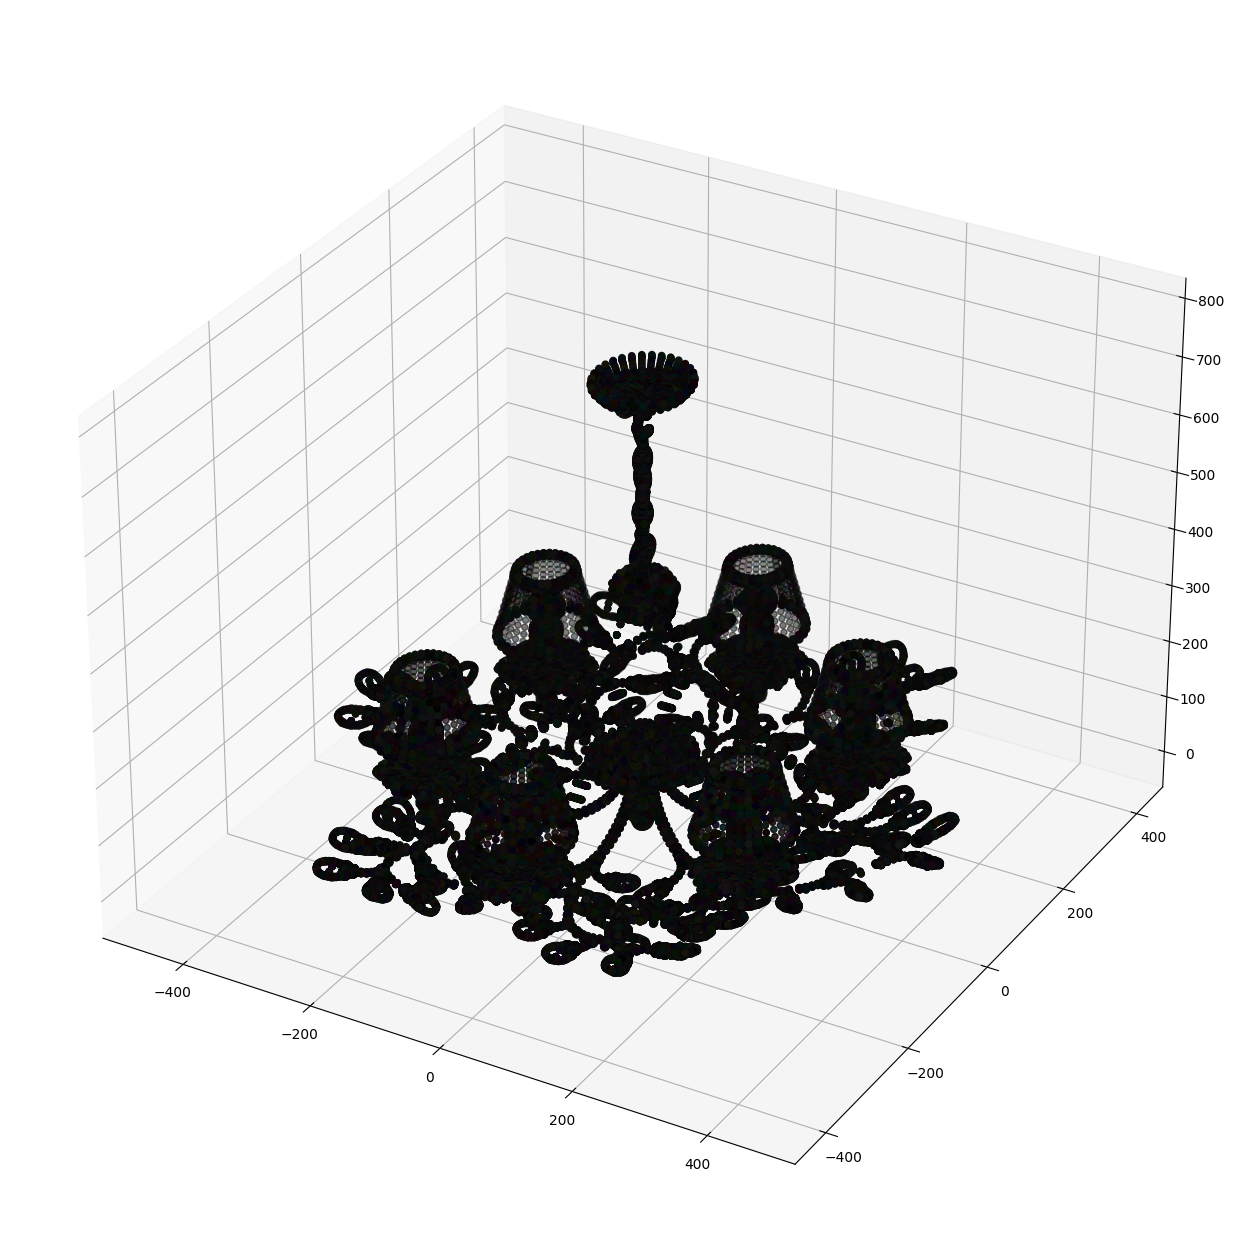

In [8]:
from mpl_toolkits.mplot3d import Axes3D

glb = model_paths[5]
m = trimesh.load(glb, force='mesh')

vertices = m.vertices
# points = trimesh.points.PointCloud(vertices, colors=colors)
points = trimesh.points.PointCloud(vertices)
p = vertices.shape[0]
colors = np.random.randint(low=0, high=25, size=(p, 3))  # Random colors
# Plot the points using matplotlib
fig = plt.figure(figsize=(25, 16))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(  points[:, 2],points[:, 0],points[:, 1], c=colors / 255.0)
# ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=)
plt.show()

In [ ]:
!pip install pygltflib

In [5]:
import numpy as np
import os
from scipy.ndimage import zoom
from multiprocessing import Pool, cpu_count
import pygltflib

In [99]:

def preprocess_glb(glb_path):
  # try:
      gltf = pygltflib.GLTF2().load(glb_path)

      # mesh = gltf.meshes[]
      # print(mesh)
      feature_vectors = []
      min_coords = np.inf * np.ones(3)  # Initialize with positive infinity
      max_coords = -np.inf * np.ones(3)  # Initialize with negative infinity

      for mesh in gltf.meshes:
          vertices_list = []
          normals_list = []
          faces_list = []
          # print(mesh)
          for primitive in mesh.primitives:
              # print(primitive)
              # Extract vertices
              vertices = np.array(primitive.attributes.POSITION)
              if vertices:
                vertices_list.append(vertices)
              # print(vertices_list)
              faces = np.array(primitive.indices)
              if faces:
                faces_list.append(faces)
              # print(faces)
              # Extract normals if available
              if primitive.attributes:
                  normals = np.array(primitive.attributes.NORMAL)
                  normals_list.append(normals)
              else:
                  # If normals are not available, you can compute them here
                  # For simplicity, let's assume all zeros
                  normals = np.zeros_like(vertices)
                  normals_list.append(normals)

              # Update bounding box
              min_coords = np.minimum(min_coords, np.min(vertices, axis=0))
              max_coords = np.maximum(max_coords, np.max(vertices, axis=0))

          # Concatenate vertices and normals for each mesh
          # vertices_concat = np.concatenate(vertices_list, axis=0)
          # normals_concat = np.concatenate(normals_list, axis=0)
          # faces_concat = np.concatenate(faces_list, axis=0)
          bounding_box = (min_coords , max_coords)
          # print(vertices_list, normals_list,faces_list, bounding_box )
              # Create feature vector for the mesh
          # feature_vector = np.concatenate((vertices_concat,faces_concat, bounding_box, normals_concat), axis=1)

              # Append feature vector to the list
          # feature_vectors.append(feature_vector)

      return vertices_list, normals_list,faces_list, bounding_box

  # except Exception as e:
  #   print(f'Error preprocessing GLB files {glb_path}: {e}')

preprocess_glb(glb)


([array(76)],
 [array(77)],
 [array(79)],
 (array([0., 0., 0.]), array([76., 76., 76.])))

In [ ]:
def preproccess_3d_model(model_path):
  try:
    vertices, faces, bounding_box, normals = preprocess_glb(model_path)

    if vertices is not None:
      voxel_grid = np.zeros((16,16,16))
      voxel_size = (vertices.max(axis=0) - vertices.min(axis=0)) / 15

      for point in vertices:
        voxel_index = ((point - vertices.min(axis=0))/ voxel_size).astype(int)

        voxel_index = np.clip(voxel_index, 0, 15)
        voxel_grid[tuple(voxel_index)] = 1

      voxel_grid_normalized = voxel_grid * 2 -1
      return voxel_grid_normalized, bounding_box, normals
    else:
      print('Error: unable to preprocess model')
      return None, None, None

  except Exception as e:
    print(f'Error preprocessing 3d Model {model_path}: {e}')
    return None, None, None


In [102]:
!pip install open3d
import open3d as o3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [10]:
import open3d as o3d

In [11]:
 mesh = o3d.io.read_triangle_mesh(glb)

In [12]:
mesh.vertices

std::vector<Eigen::Vector3d> with 355247 elements.
Use numpy.asarray() to access data.